# *DESAFIO 1*

- #### Como primer medida vamos a importar las librerías que vamos a utilizar a lo largo de la notebook, y todas las herramientas que creamos necesarias. 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import re 

%matplotlib inline

- #### El siguiente paso es importar el Dataset y comenzar a revisarlo

In [2]:
data_location = 'C:/Users/USUARIO/Desktop/Digital House - DS/Data Sets/properatti.csv'
data = pd.read_csv(data_location)

print(data.shape, '\n')

# hacemos un describe para ver algunos datos estadisticos del dataset 
print(data.describe())

# mostramos el porcentaje de nulos que tiene cada columna del dataset 
print(data.isnull().sum() / data.shape[0])

(121220, 26) 

          Unnamed: 0   geonames_id           lat           lon         price  \
count  121220.000000  1.025030e+05  69670.000000  69670.000000  1.008100e+05   
mean    60609.500000  3.574442e+06    -34.626210    -59.266290  4.685259e+05   
std     34993.344153  3.541306e+05      1.980936      2.299922  2.260101e+06   
min         0.000000  3.427208e+06    -54.823985    -75.678931  0.000000e+00   
25%     30304.750000  3.430234e+06    -34.669065    -58.727040  1.100000e+05   
50%     60609.500000  3.433910e+06    -34.597985    -58.480128  1.850000e+05   
75%     90914.250000  3.836668e+06    -34.441299    -58.395908  4.200000e+05   
max    121219.000000  6.948895e+06      4.545843    -53.733330  6.500000e+08   

       price_aprox_local_currency  price_aprox_usd  surface_total_in_m2  \
count                1.008100e+05     1.008100e+05         81892.000000   
mean                 4.229397e+06     2.397006e+05           233.795328   
std                  6.904714e+06     3

- #### Creamos un nuevo dataset con las columnas mas relevantes, sobre las que vamos a llevar a cabo la limpieza e imputación de datos

In [3]:
data_final = data[['property_type','place_name','place_with_parent_names','state_name','price','currency','price_aprox_usd',
                         'surface_total_in_m2','surface_covered_in_m2','price_per_m2','rooms','description','title']].copy()

# La columna 'expenses', si bien podría haber aportado información relevante, la desestimamos debido a su alto porcentaje de nulos.  

print('Cantidad de NO nulos en la columna expenses --->', data['expenses'].notnull().sum(), '\n')
print('Cantidad total de filas en la columna expenses --->', data['expenses'].shape[0], '\n')

# Evaluamos nuestro dataset final donde llevaremos a cabo la limpieza e imputación de datos. Vemos que la cantidad de nulos de las columnas
# sea baja para poder comenzar a trabajar. 

print(data_final.isnull().sum() / data_final.shape[0], '\n')

Cantidad de NO nulos en la columna expenses ---> 14262 

Cantidad total de filas en la columna expenses ---> 121220 

property_type              0.000000
place_name                 0.000190
place_with_parent_names    0.000000
state_name                 0.000000
price                      0.168372
currency                   0.168380
price_aprox_usd            0.168372
surface_total_in_m2        0.324435
surface_covered_in_m2      0.164222
price_per_m2               0.276869
rooms                      0.609058
description                0.000016
title                      0.000000
dtype: float64 



- #### Miramos si hay valores duplicados. En caso de que los haya, los eliminamos

In [4]:
duplicados = data_final.duplicated()
print(duplicados.shape[0])
print(duplicados.sum())
print('----')

data_final.loc[duplicados].head(40)
data_final.drop_duplicates(inplace=True)

print(data_final.shape[0])

121220
5410
----
115810


In [5]:
data_final.drop_duplicates(inplace=True)
print(data_final.shape[0])

115810


- #### *Investigamos la columna price*

In [6]:
print('Tamaño columna price --->', data_final['price'].shape[0], '\n')
print('Valores nulos columna price --->', data_final['price'].isnull().sum(), '\n')
print('Valores NO nulos columna price --->', data_final['price'].notnull().sum(), '\n')
print(data_final['price'].describe(), '\n')

Tamaño columna price ---> 115810 

Valores nulos columna price ---> 17374 

Valores NO nulos columna price ---> 98436 

count    9.843600e+04
mean     4.647985e+05
std      2.272420e+06
min      0.000000e+00
25%      1.100000e+05
50%      1.850000e+05
75%      4.184175e+05
max      6.500000e+08
Name: price, dtype: float64 



- #### Verificamos que no haya datos faltantes y que todos los precios expresados en ARS estén en la columna price_aprox_usd denominados en USD. 

In [7]:
price_aprox_usd = data_final['price_aprox_usd']
pesos_mask = data_final['currency'] == 'ARS'
price_pesos = data_final.loc[pesos_mask]

In [8]:
print('Cantidad de precio aproximado en USD para los valores expresados ARS --->', price_aprox_usd[pesos_mask].shape[0], '\n')
print('Cantidad de  precios expresados en ARS --->', data_final[pesos_mask].shape[0])

Cantidad de precio aproximado en USD para los valores expresados ARS ---> 12646 

Cantidad de  precios expresados en ARS ---> 12646


- #### Lo primero que tenemos que hacer es pasar los precios expresados en pesos a valores en dolares, utilizando la columna price_aprox_usd. 
- #### Luego vamos a mirar como se distribuyen los valores de cada property_type, si no tienen muchos outliers, imputaremos los datos faltantes por el precio promedio de cada tipo de propiedad; si tienen muchos outliers utilizaremos la mediana para no sesgar los resultados.  


In [9]:
data_final['priceusd'] = data_final['price']
data_final.loc[pesos_mask ,'priceusd'] = data_final.loc[pesos_mask,'price_aprox_usd']

In [10]:
# En estas líneas de código corroboramos que los precios denominados en pesos, cambiaron a su aproximado en dolares. 

priceusd_check = data_final.loc[:,['priceusd','property_type','price_aprox_usd']]
print(priceusd_check[pesos_mask], '\n')

# Una vez que logramos trabajar con todos los valores en usd, vamos a visualizar si hay outliers en los precios de cada uno de los tipos de 
# propiedades, para definir el tipo de imputación a la columna price.

data_final['property_type'].value_counts()

         priceusd property_type  price_aprox_usd
9        25798.49         house         25798.49
32       30846.02     apartment         30846.02
37       70104.59         house         70104.59
78      308460.22         house        308460.22
97       79851.93     apartment         79851.93
...           ...           ...              ...
121199   84237.68     apartment         84237.68
121200   84013.34     apartment         84013.34
121202   84518.10     apartment         84518.10
121203   84237.68     apartment         84237.68
121205   84518.10     apartment         84518.10

[12646 rows x 3 columns] 



apartment    66418
house        39712
PH            5613
store         4067
Name: property_type, dtype: int64

In [11]:
# Los valores en la columna price usd son los valores en dólares y los valores aproximados en dólares de las propiedades denominadas en pesos. 

print(data_final['priceusd'].notnull().sum())

print(data_final['price_aprox_usd'].isnull().sum())
print(data_final['price_aprox_usd'].shape[0])


98436
17374
115810


- #### Variable de los precios por tipo de propiedad 

In [12]:
price = data_final['priceusd']
property_type_PH = data_final['property_type'] == 'PH' 
PH_price = price[property_type_PH]

price = data_final['priceusd']
property_type_apartment = data_final['property_type'] == 'apartment' 
apartment_price = price[property_type_apartment]

price = data_final['priceusd']
property_type_house = data_final['property_type'] == 'house' 
house_price = price[property_type_house]

price = data_final['priceusd']
property_type_store = data_final['property_type'] == 'store' 
store_price = price[property_type_store]

- #### Porcentaje de nulos por tipo de propiedad

In [13]:
print('Cantidad de nulos en PH --->', PH_price.isnull().sum() / PH_price.shape[0] , '\n')
print('Cantidad de nulos en apartment --->', apartment_price.isnull().sum() / apartment_price.shape[0] , '\n')
print('Cantidad de nulos en house --->', house_price.isnull().sum() / house_price.shape[0] , '\n')
print('Cantidad de nulos en store --->', store_price.isnull().sum() / store_price.shape[0] , '\n')

Cantidad de nulos en PH ---> 0.08070550507749866 

Cantidad de nulos en apartment ---> 0.1325694841759764 

Cantidad de nulos en house ---> 0.18289182111200644 

Cantidad de nulos en store ---> 0.20973690681091714 



- #### Calculo outliers

In [14]:
print('PH','\n')

Q1_PH_price = PH_price.quantile(0.25)
print('Primer Cuartil --->', Q1_PH_price, '\n')

Q3_PH_price = PH_price.quantile(0.75)
print('Tercer Cuartil --->', Q3_PH_price, '\n')

IQR_PH_price = Q3_PH_price - Q1_PH_price
print('Rango Intercuartil --->', IQR_PH_price, '\n')

Media_PH_price = PH_price.mean()
print('Media', Media_PH_price, '\n')

Mediana_PH_price = PH_price.median()
print('Mediana', Mediana_PH_price, '\n')

Valor_Minimo_PH_price = PH_price.min()
print('Valor mínimo', Valor_Minimo_PH_price, '\n')

Valor_Maximo_PH_price = PH_price.max()
print('Valor máximo', Valor_Maximo_PH_price, '\n')


# OUTLIERS

PH_price_outliers_calculo = (PH_price < Q1_PH_price) | (PH_price > Q3_PH_price)
PH_price_outliers = PH_price_outliers_calculo.sum()
print('La cantidad de outliers dentro de PH_price es --->', PH_price_outliers, '\n')
PH_price_values = PH_price.shape[0] - PH_price.isnull().sum()
print('Porcentaje de outliers dentro de PH_price --->', PH_price_outliers * 100 / PH_price_values, '\n')

PH 

Primer Cuartil ---> 85000.0 

Tercer Cuartil ---> 165000.0 

Rango Intercuartil ---> 80000.0 

Media 147823.07622093023 

Mediana 120000.0 

Valor mínimo 5047.53 

Valor máximo 2800000.0 

La cantidad de outliers dentro de PH_price es ---> 2544 

Porcentaje de outliers dentro de PH_price ---> 49.30232558139535 



In [15]:
print('APARTMENT', '\n')

Q1_apartment_price = apartment_price.quantile(0.25)
print('Primer Cuartil --->', Q1_apartment_price, '\n')

Q3_apartment_price = apartment_price.quantile(0.75)
print('Tercer Cuartil --->', Q3_apartment_price, '\n')

IQR_apartment_price = Q3_apartment_price - Q1_apartment_price
print('Rango Intercuartil --->', IQR_apartment_price, '\n')

Media_apartment_price = apartment_price.mean()
print('Media', Media_apartment_price, '\n')

Mediana_apartment_price = apartment_price.median()
print('Mediana', Mediana_apartment_price, '\n')

Valor_Minimo_apartment_price = apartment_price.min()
print('Valor mínimo', Valor_Minimo_apartment_price, '\n')

Valor_Maximo_apartment_price = apartment_price.max()
print('Valor máximo', Valor_Maximo_apartment_price, '\n')


# OUTLIERS

apartment_price_outliers_calculo = (apartment_price < Q1_apartment_price) | (apartment_price > Q3_apartment_price)
apartment_price_outliers = apartment_price_outliers_calculo.sum()
print('La cantidad de outliers dentro de apartment_price es --->', apartment_price_outliers, '\n')
apartment_price_values = apartment_price.shape[0] - apartment_price.isnull().sum()
print('Porcentaje de outliers dentro de apartment_price --->', apartment_price_outliers * 100 / apartment_price_values, '\n')

APARTMENT 

Primer Cuartil ---> 80000.0 

Tercer Cuartil ---> 193000.0 

Rango Intercuartil ---> 113000.0 

Media 188326.64519830592 

Mediana 119900.0 

Valor mínimo 4666.62 

Valor máximo 46545445.0 

La cantidad de outliers dentro de apartment_price es ---> 28347 

Porcentaje de outliers dentro de apartment_price ---> 49.202436949993924 



In [16]:
Q1_house_price = house_price.quantile(0.25)
print('Primer Cuartil --->', Q1_house_price, '\n')

Q3_house_price = house_price.quantile(0.75)
print('Tercer Cuartil --->', Q3_house_price, '\n')

IQR_house_price = Q3_house_price - Q1_house_price
print('Rango Intercuartil --->', IQR_house_price, '\n')

Media_house_price = house_price.mean()
print('Media', Media_house_price, '\n')

Mediana_house_price = house_price.median()
print('Mediana', Mediana_house_price, '\n')

Valor_Minimo_house_price = house_price.min()
print('Valor mínimo', Valor_Minimo_house_price, '\n')

Valor_Maximo_house_price = house_price.max()
print('Valor máximo', Valor_Maximo_house_price, '\n')

# OUTLIERS

house_price_outliers_calculo = (house_price < Q1_house_price) | (house_price > Q3_house_price)
house_price_outliers = house_price_outliers_calculo.sum()
print('La cantidad de outliers dentro de house_price es --->', house_price_outliers, '\n')
print('Cantidad de valores netos dentro de house_price --->', house_price.shape[0] - house_price.isnull().sum(), '\n')
house_price_values = house_price.shape[0] - house_price.isnull().sum()
print('Porcentaje de outliers dentro de house_price --->', house_price_outliers * 100 / house_price_values, '\n')

Primer Cuartil ---> 140000.0 

Tercer Cuartil ---> 380000.0 

Rango Intercuartil ---> 240000.0 

Media 348668.50439951924 

Mediana 240000.0 

Valor mínimo 0.0 

Valor máximo 650000000.0 

La cantidad de outliers dentro de house_price es ---> 16101 

Cantidad de valores netos dentro de house_price ---> 32449 

Porcentaje de outliers dentro de house_price ---> 49.61940275509261 



In [17]:
print('STORE')

Q1_store_price = store_price.quantile(0.25)
print('Primer Cuartil --->', Q1_store_price, '\n')

Q3_store_price = store_price.quantile(0.75)
print('Tercer Cuartil --->', Q3_store_price, '\n')

IQR_store_price = Q3_store_price - Q1_store_price
print('Rango Intercuartil --->', IQR_store_price, '\n')

Media_store_price = store_price.mean()
print('Media', Media_store_price, '\n')

Mediana_store_price = store_price.median()
print('Mediana', Mediana_store_price, '\n')

Valor_Minimo_store_price = store_price.min()
print('Valor mínimo', Valor_Minimo_store_price, '\n')

Valor_Maximo_store_price = store_price.max()
print('Valor máximo', Valor_Maximo_store_price, '\n')


# OUTLIERS

store_price_outliers_calculo = (store_price < Q1_store_price) | (store_price > Q3_store_price)
store_price_outliers = store_price_outliers_calculo.sum()
print('La cantidad de outliers dentro de store_price es --->', store_price_outliers, '\n')
print('Cantidad de valores netos dentro de store_price --->', store_price.shape[0] - store_price.isnull().sum(), '\n')
store_price_values = store_price.shape[0] - store_price.isnull().sum()
print('Porcentaje de outliers dentro de store_price --->', store_price_outliers * 100 / store_price_values, '\n')

STORE
Primer Cuartil ---> 95000.0 

Tercer Cuartil ---> 450000.0 

Rango Intercuartil ---> 355000.0 

Media 439801.60409769765 

Mediana 210000.0 

Valor mínimo 4952.45 

Valor máximo 13000000.0 

La cantidad de outliers dentro de store_price es ---> 1577 

Cantidad de valores netos dentro de store_price ---> 3214 

Porcentaje de outliers dentro de store_price ---> 49.066583696328564 



In [18]:
data_final['price'].sort_values(ascending = False).head(10)

107390    650000000.0
65701      99999999.0
91368      56500000.0
64134      50000000.0
64137      50000000.0
64131      50000000.0
64132      50000000.0
24548      46545445.0
116337     30000000.0
91468      25000000.0
Name: price, dtype: float64

- #### En el gráfico podemos ver que la cantidad de outliers en todas las propiedades es muy grande, por eso imputaremos los datos faltantes de la columna price por la mediana de cada tipo de propiedad.

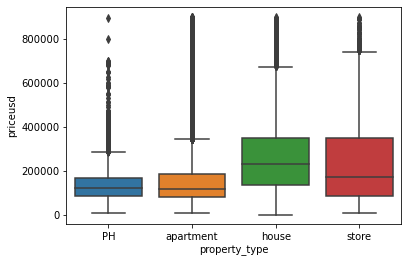

In [19]:
mask = data_final['priceusd'] < 900000
fig = sns.boxplot(data = data_final.loc[mask,['priceusd','property_type']], x ='property_type', y = 'priceusd')

- #### También vemos que a medida que aumentamos el valor del precio en la máscara, nos muestra cada vez más outliers. 

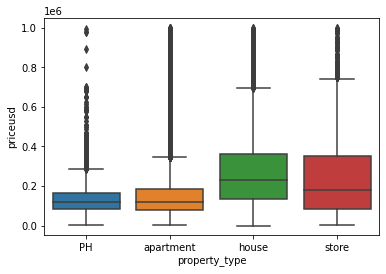

In [20]:
mask = data_final['priceusd'] < 1000000
fig = sns.boxplot(data = data_final.loc[mask,['priceusd','property_type']], x ='property_type', y = 'priceusd')

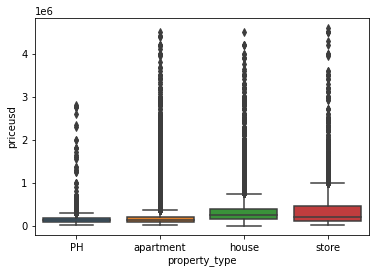

In [21]:
mask = data_final['priceusd'] < 5000000
fig = sns.boxplot(data = data_final.loc[mask,['priceusd','property_type']], x ='property_type', y = 'priceusd')

- #### Imputación de valores nulos 

In [22]:
data_final['property_type'].value_counts()

apartment    66418
house        39712
PH            5613
store         4067
Name: property_type, dtype: int64

- #### Imputamos PH

In [23]:
PH_priceusd_median = PH_price.median()
PH_priceusd_null_count = PH_price.isnull().sum()
PH_priceusd_notnull_count = PH_price.notnull().sum()

print(PH_priceusd_notnull_count)
print('----')
print(PH_priceusd_null_count)

5160
----
453


In [24]:
# Imputamos los datos 

PH_price.fillna(PH_priceusd_median, axis=0, inplace=True)

print(PH_price.isnull().sum())

0


- #### Imputamos Apartment

In [25]:
apartment_priceusd_median = apartment_price.median()
apartment_priceusd_null_count = apartment_price.isnull().sum()
apartment_priceusd_notnull_count = apartment_price.notnull().sum()

print(apartment_priceusd_notnull_count)
print('----')
print(apartment_priceusd_null_count)

57613
----
8805


In [26]:
# Imputamos los datos 

apartment_price.fillna(apartment_priceusd_median, axis=0, inplace=True)

print(apartment_price.isnull().sum())

0


- #### Imputamos House

In [27]:
house_priceusd_median = house_price.median()
house_priceusd_null_count = house_price.isnull().sum()
house_priceusd_notnull_count = house_price.notnull().sum()

print(house_priceusd_notnull_count)
print('----')
print(house_priceusd_null_count)

32449
----
7263


In [28]:
# Imputamos los datos 

house_price.fillna(apartment_priceusd_median, axis=0, inplace=True)

print(house_price.isnull().sum())

0


- #### Imputamos Store

In [29]:
store_priceusd_median = store_price.median()
store_priceusd_null_count = store_price.isnull().sum()
store_priceusd_notnull_count = store_price.notnull().sum()

print(store_priceusd_notnull_count)
print('----')
print(store_priceusd_null_count)

3214
----
853


In [30]:
# Imputamos los datos 

store_price.fillna(store_priceusd_median, axis=0, inplace=True)

print(store_price.isnull().sum())

0


- #### Volvemos a graficar para ver los cambios en los datos luego de la imputación. 

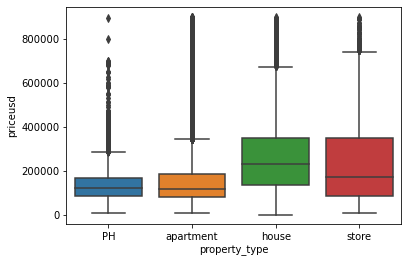

In [31]:
mask = data_final['priceusd'] < 900000
fig = sns.boxplot(data = data_final.loc[mask,['priceusd','property_type']], x ='property_type', y = 'priceusd')

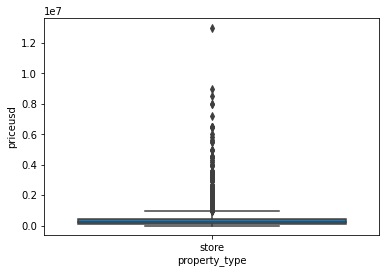

In [32]:
maskk = data_final['property_type'] == 'store'
histplot_PH = sns.boxplot(data= data_final.loc[maskk,['property_type','priceusd']], x= 'property_type', y = 'priceusd')

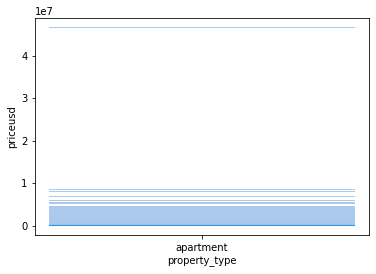

In [33]:
maskk = data_final['property_type'] == 'apartment' 
histplot_PH = sns.histplot(data= data_final.loc[maskk,['property_type','priceusd']], x= 'property_type', y = 'priceusd')

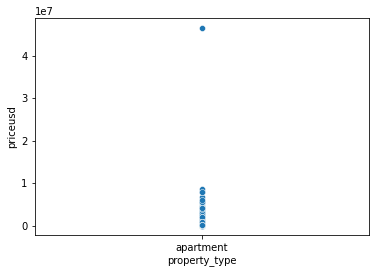

In [34]:
maskk = data_final['property_type'] == 'apartment' 
histplot_PH = sns.scatterplot(data= data_final.loc[maskk,['property_type','priceusd']], x= 'property_type', y = 'priceusd')

In [35]:
# dataset para el grupo 

#data_test = data_final[['property_type','place_name','place_with_parent_names','state_name','priceusd','surface_total_in_m2',
#                        'surface_covered_in_m2','price_per_m2','rooms','description','title']]